In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import warnings
import pandas as pd
from astropy.wcs import WCS
warnings.filterwarnings("ignore")
from numpy.fft import rfft2, irfft2, ifftshift
from scipy.signal import fftconvolve
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from astropy.nddata import Cutout2D
import gc
from astropy.wcs.utils import proj_plane_pixel_scales
import astropy.units as u
import os
from multiprocessing import get_context

In [2]:
mer_catalog = {'53.0_-28.0': 'EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits',
               '58.9_-48.6': 'EUC_MER_FINAL-CAT_TILE102021011-3A8DD3_20241020T112743.867901Z_00.00.fits'}

In [3]:
# Set location of the data
location = '/net/vdesk/data2/deklerk/GAAP_data'

# Set the field
field = '53.0_-28.0'

In [4]:
with fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/{mer_catalog[field]}', memmap=True) as hdul:
    hdul.info()
    cat = Table(hdul[1].data)

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/53.0_-28.0/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1464   96164R x 470C   [K, D, D, D, D, K, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

In [19]:
fluxes = pd.read_csv(f'/net/vdesk/data2/deklerk/GAAP_data/{field}/fluxes.csv')

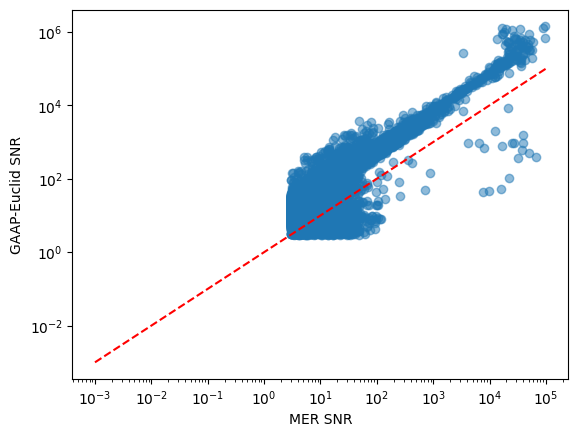

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.9772573166932395
Average SNR improvement factor (GAAP-Euclid / MER): 5.379087394060955


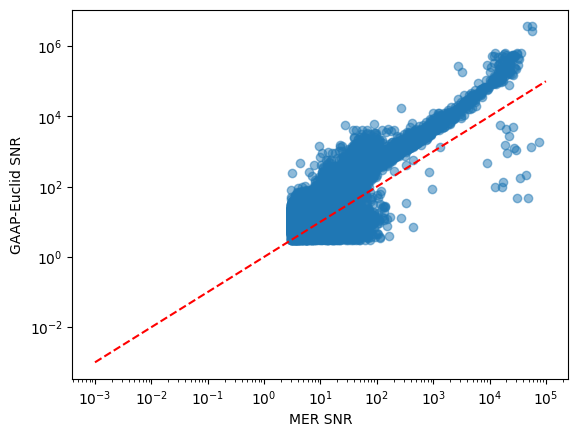

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.9603204823100111
Average SNR improvement factor (GAAP-Euclid / MER): 4.2492561246558145


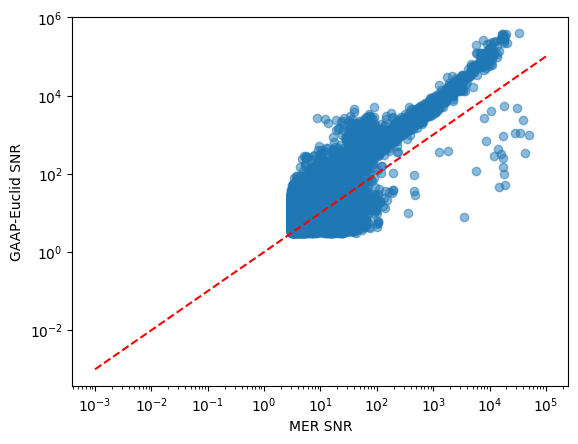

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.9608247824139878
Average SNR improvement factor (GAAP-Euclid / MER): 4.569643023724053


In [6]:
for filter in ['G', 'R', 'I']:
    snr_meer = cat[f'FLUX_{filter}_EXT_DECAM_4FWHM_APER'] / cat[f'FLUXERR_{filter}_EXT_DECAM_4FWHM_APER']
    snr_gaap_euclid = fluxes[f'flux_DES-{filter}']/fluxes[f'flux_DES-{filter}_sigma']
    cutoff_snr = 3
    mask = (snr_meer > cutoff_snr) & (snr_gaap_euclid > cutoff_snr) & (np.isfinite(snr_gaap_euclid)) & (np.isfinite(snr_meer))
    plt.scatter(snr_meer[mask],
                snr_gaap_euclid[mask],
                alpha=0.5)
    plt.plot([1e-3, 1e5], [1e-3, 1e5], 'r--')
    plt.xlabel('MER SNR')
    plt.ylabel('GAAP-Euclid SNR')
    plt.loglog()
    plt.show()
    print("Percent of sources where GAAP-Euclid SNR > MER SNR:", np.nansum(snr_gaap_euclid[mask] > snr_meer[mask])/ np.sum(~np.isnan(snr_gaap_euclid[mask])))
    print("Average SNR improvement factor (GAAP-Euclid / MER):", np.nanmean(snr_gaap_euclid[mask] / snr_meer[mask]))

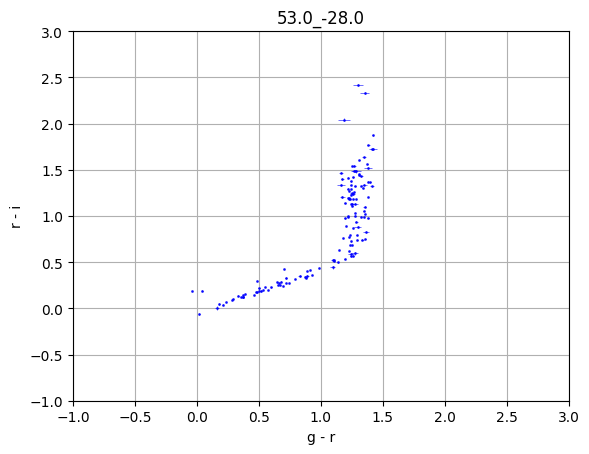

In [13]:
filter_1 = 'flux_g'   # e.g., master_table column name
filter_2 = 'flux_r'
filter_3 = 'flux_r'
filter_4 = 'flux_i'

plot_error = True

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
        (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
        (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
    )

    # Select star based on MER catalog
    mask = cat['POINT_LIKE_PROB'] > 0.9
    gaap_error = xerr**2 + yerr**2
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
    )

    plt.title(f'{field}')
    plt.xlabel(f'{filter_1[5:]} - {filter_2[5:]}')
    plt.ylabel(f'{filter_3[5:]} - {filter_4[5:]}')
    plt.xlim(-1, 3)
    plt.ylim(-1, 3)
    plt.show()

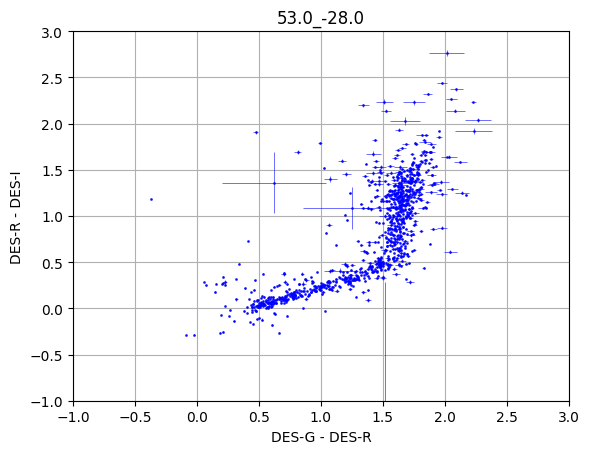

In [10]:
filter_1 = 'flux_DES-G'   # e.g., master_table column name
filter_2 = 'flux_DES-R'
filter_3 = 'flux_DES-R'
filter_4 = 'flux_DES-I'

plot_error = True
with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
        (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
        (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
    )

    gaap_error = xerr**2 + yerr**2
    # Select star based on MER catalog
    mask = cat['POINT_LIKE_PROB'] > 0.9
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
    )

    plt.title(f'{field}')
    plt.xlabel(f'{filter_1[5:]} - {filter_2[5:]}')
    plt.ylabel(f'{filter_3[5:]} - {filter_4[5:]}')
    plt.xlim(-1, 3)
    plt.ylim(-1, 3)
    plt.show()

In [18]:
fluxes

,dec,aperture_size,flux_u,flux_u_sigma,flux_g,flux_g_sigma,flux_r,flux_r_sigma,flux_i,flux_i_sigma,...,flux_DES-R,flux_DES-R_sigma,flux_DES-I,flux_DES-I_sigma,flux_NIR-Y,flux_NIR-Y_sigma,flux_NIR-J,flux_NIR-J_sigma,flux_NIR-H,flux_NIR-H_sigma
ra,,,,,,,,,,,,,,,,,,,,,
53.157185,-28.254257,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,56.222355,2.948168,66.962409,5.346565,78.519428,7.350121,158.481705,6.411058,194.220603,7.024942
52.816362,-28.254012,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42.331618,2.948168,69.108516,5.346565,176.757705,7.350121,61.973429,6.411058,85.576415,7.024942
52.707227,-28.253847,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-29.401046,2.948168,-24.870498,5.346565,0.375568,7.350121,15.327030,6.411058,-157.172155,7.024942
52.761280,-28.253924,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,258.009601,2.948168,242.946529,5.346565,394.063282,7.350121,553.715611,6.411058,764.871264,7.024942
53.233772,-28.253921,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,117.379355,2.948168,183.507884,5.346565,140.401328,7.350121,238.232517,6.411058,290.876150,7.024942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52.762204,-27.748261,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.723111,2.948168,-13.575615,5.346565,4.300852,7.350121,-39.098364,6.411058,35.287887,7.024942
53.002813,-27.748525,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.993338,2.948168,-30.719209,5.346565,-0.576466,7.350121,21.006070,6.411058,69.812149,7.024942
53.002641,-27.748209,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.140499,2.948168,25.219831,5.346565,17.160714,7.350121,15.682976,6.411058,42.473975,7.024942
